Pruebas en el modelo v6

In [21]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
import cv2
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from detectors.detector_factory import detector_factory

image_ext = ['jpg', 'jpeg', 'png', 'webp']
video_ext = ['mp4', 'mov', 'avi', 'mkv']
time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']

In [22]:
def _nms(heat, kernel=3):
    pad = (kernel - 1) // 2

    hmax = torch.nn.functional.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=pad)
    keep = (hmax == heat).float()
    return heat * keep

In [23]:
sys.argv = ['-f', 'ctdetv2', '--demo', '../images/yolo/', '--arch','dlav6_34',  '--load_model' ,'../exp/ctdetv2/coco_dlav6/model_last.pth'] #cmd = 'ctdet --exp_id coco_dla --batch_size 4 --lr 1.25e-4  --gpus 0 --num_workers 0'
opt = opts().parse()
print(opt.task)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\ctdetv2\default
ctdetv2


In [24]:
opt = opts().init()

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\ctdetv2\default
heads {'hm': 80, 'wh': 2, 'reg': 2}


In [25]:
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.debug = max(opt.debug, 1)
opt.debug = 0
Detector = detector_factory[opt.task]
detector = Detector(opt)

Creating model...
loaded ../exp/ctdetv2/coco_dlav6/model_last.pth, epoch 240


In [26]:
detector.model

DLASeg(
  (base): DLA(
    (base_layer): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level0): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level2): Tree(
      (tree1): BasicBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [73]:
loaded_embedding_matrix = torch.load('embedding_matrix.pth')
clases = ['aceite', 'aerosol', 'azucarero', 'balsamo', 'borrador', 'cafe', 'cera', 'cloro', 'cloroplano', 'coca', 'colador', 'confort',
           'crema', 'cubix', 'desodorante', 'durazno', 'esponja', 'estuche', 'greda', 'guante', 'harina', 'jabon', 'jugoind', 'ketchup',
           'lata', 'leche', 'limon', 'linterna', 'mantequilla', 'mostaza', 'papas', 'pelota', 'pepino', 'pescado', 'platano', 'platoperro',
           'sarten', 'te', 'uslero', 'yogurt']

In [104]:
clases[30]

'papas'

In [28]:
image_names = []
image_names.append('../images/test/3_imgrgb.png')

In [59]:
from torch.nn.functional import normalize
import numpy as np
def cosdis(x,y):
    x = x.unsqueeze(0)
    y = y.unsqueeze(1)
    x_n = normalize(x,dim=1)
    y_n = normalize(y,dim=0)
    return x_n@y_n

In [117]:
descriptores = {}
descriptores2 = {}
m = torch.nn.ReLU()
for (image_name) in image_names:
    print(image_name)
    ret = detector.run(image_name)
    output = ret['output']
    pred_obj = output['objns']
    wh = output['wh'] #torch.Size([1, 2, 128, 128])
    reg = output['reg'] #torch.Size([1, 2, 128, 128])
    pred_obj = _nms(pred_obj)
    hm = pred_obj.squeeze(0).squeeze(0)
    scores = output['hm'].squeeze(0)
    batch, cat, height, width = pred_obj.size()
    
    K=8
    topk_scores, topk_inds = torch.topk(pred_obj.view(batch, cat, -1), K) #top 100 pixeles brillantes
    topk_inds = topk_inds.view(-1,K)

    topk_inds = topk_inds % (height * width)
    topk_ys   = (topk_inds / width).int()
    topk_ys   = topk_ys.view(-1,topk_ys.shape[-1])
    topk_xs   = (topk_inds % width).int()
    topk_xs   = topk_xs.view(-1,topk_xs.shape[-1])
    
    #Calculo de los topk wh
    top_wh = wh.permute(0,2,3,1).contiguous()
    top_wh = top_wh.view(top_wh.size(0),-1,top_wh.size(3))
    ind = topk_inds.unsqueeze(2).expand(topk_inds.size(0), topk_inds.size(1), top_wh.size(2))
    top_wh = top_wh.gather(1, ind) #torch.Size([1, 15, 2])
    
    #Calculo de los topk reg
    top_reg = reg.permute(0,2,3,1).contiguous()
    top_reg = top_reg.view(top_reg.size(0),-1,top_reg.size(3))
    top_reg = top_reg.gather(1, ind) #torch.Size([1, 15, 2])
    
    topk_xs = topk_xs.view(1,K,1) + top_reg[:,:,0:1]
    topk_ys = topk_ys.view(1,K,1) + top_reg[:,:,1:2]
    
    bboxes = torch.cat([topk_xs - top_wh[..., 0:1] / 2, 
                        topk_ys - top_wh[..., 1:2] / 2,
                        topk_xs + top_wh[..., 0:1] / 2, 
                        topk_ys + top_wh[..., 1:2] / 2], dim=2).cpu()
    
    
    labels = []
    new_bboxes = []
    for bbox in bboxes[0]:
        radio = 1
        eje_x, eje_y = int((bbox[0]+bbox[2])/2), int((bbox[0]+bbox[2])/2)
        

        descriptor = output['descriptor'].squeeze(0)[:,eje_x,eje_y]
        count = 1
        for x in range(eje_x - radio, eje_x + radio+1):
            for y in range(eje_y - radio, eje_y + radio+1):
                if not (x==eje_x and y==eje_y):
                    descriptor = (descriptor+output['descriptor'].squeeze(0)[:,eje_x,eje_y])
                    count += 1
        descriptor = descriptor/count
        cosdis_mat = torch.tensor([cosdis(embedding,descriptor) for embedding in loaded_embedding_matrix])
        print(cosdis_mat[30])
        print(eje_x,eje_y,cosdis_mat[torch.argmax(cosdis_mat)],torch.argmax(cosdis_mat))
        labels.append(torch.argmax(cosdis_mat))
        if (cosdis_mat[torch.argmax(cosdis_mat)]>0.80):
            new_bboxes.append(bbox)
        
    new_bboxes = torch.stack(new_bboxes)
    print('-------------------------')

../images/test/3_imgrgb.png
tensor(0.8775)
77 77 tensor(0.9389) tensor(6)
tensor(0.8030)
57 57 tensor(0.8525) tensor(16)
tensor(0.7993)
50 50 tensor(0.8597) tensor(16)
tensor(0.7994)
65 65 tensor(0.8814) tensor(16)
tensor(0.7940)
47 47 tensor(0.8586) tensor(16)
tensor(0.6519)
126 126 tensor(0.7460) tensor(19)
tensor(0.8584)
70 70 tensor(0.8883) tensor(16)
tensor(0.5728)
15 15 tensor(0.6331) tensor(20)
-------------------------


In [112]:
bboxes[0][0]

tensor([72.4791, 67.8735, 82.8488, 81.6815])

In [120]:
import numpy as np
h_inp, w_inp = cv2.imread(image_name).shape[0:2]
c = np.array([w_inp / 2., h_inp / 2.], dtype=np.float32)
s = max(h_inp, w_inp) * 1.0 #s = scale = scale_tmp =src_w
print(h_inp, w_inp, c, s)

480 640 [320. 240.] 640.0


In [121]:
src = np.zeros((3, 2), dtype=np.float32)
dst = np.zeros((3, 2), dtype=np.float32)
src[0,:] = [320., 240.]
src[1,:] = [320., -80.]
src[2,:] = [  0., -80.]
dst[0,:] = [64.0, 64.0]
dst[1,:] = [64.,  0.]
dst[2,:] = [0., 0.]
trans = cv2.getAffineTransform(np.float32(dst),np.float32(src))
print(trans)

[[  5.  -0.   0.]
 [  0.   5. -80.]]


In [127]:
for i in range(2):
    coords = new_bboxes[:,0+2*i:2+2*i]
    print(coords)
    target_coords = np.zeros(coords.shape)
    for p in range(coords.shape[0]):
        target_coords[p, 0:2] = np.dot(trans, np.array([coords[p,0], coords[p,1], 1.], dtype=np.float32).T)
    
    new_bboxes[:,0+2*i:2+2*i] = torch.tensor([target_coords])
       
    

tensor([[72.4791, 67.8735],
        [53.6780, 64.5633],
        [45.4235, 82.0008],
        [62.7729, 70.5452],
        [42.3537, 58.7346],
        [67.7375, 80.0669]])
tensor([[82.8488, 81.6815],
        [61.2354, 80.3838],
        [55.2599, 88.4868],
        [68.4530, 80.8489],
        [52.9950, 79.6077],
        [73.9287, 88.5153]])


In [128]:
image = cv2.imread(image_name)
# Blue color in BGR 
color = (255, 0, 0) 
  
# Line thickness of 2 px 
thickness = 2

for numero, bbox in enumerate(new_bboxes):
    bbox = np.array(bbox.cpu(), dtype=np.int32)
    image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness) 
    image = cv2.putText(image, clases[labels[numero]], (bbox[0], bbox[1] - 2), 
                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    
    print(bbox)

[362 259 414 328]
[268 242 306 321]
[227 330 276 362]
[313 272 342 324]
[211 213 264 318]
[338 320 369 362]


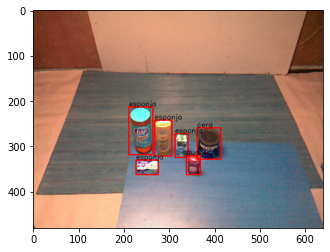

In [171]:
plt.imshow(image) 

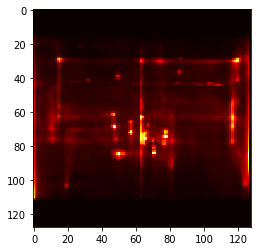

In [14]:
plt.imshow(output['objns'][0,0].detach().cpu().numpy(), cmap='hot', interpolation='nearest')

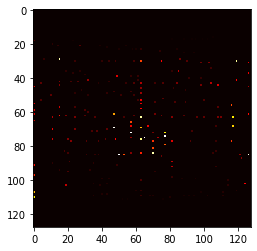

In [15]:
plt.imshow(pred_obj[0,0].detach().cpu().numpy(), cmap='hot', interpolation='nearest')

In [172]:
cv2.imwrite('prueba.png', image)

True

# Calculo de IoU Para una imagen (esto utiliza el codigo de arriba)

Precision = Objetos Correctamente detectados de las predicciones realizadas (TP/TP+FP) (Correct/proposals) <br>
Recall = Objetos Correctamente detectados de todos los objetos (TP/TP+FN) (Correct/total objetos GT) <br>
FP:= Objetos que detectó erroneamente. <br>
FN:= Objetos que debía detectar, pero no detectó. 

In [9]:
def bbox_iou(box1, box2):
    mx = min(box1[0], box2[0])
    Mx = max(box1[2], box2[2])
    my = min(box1[1], box2[1])
    My = max(box1[3], box2[3])
    w1 = box1[2] - box1[0]
    h1 = box1[3] - box1[1]
    w2 = box2[2] - box2[0]
    h2 = box2[3] - box2[1]
    
    uw = Mx - mx
    uh = My - my
    cw = w1 + w2 - uw
    ch = h1 + h2 - uh
    carea = 0
    if cw <= 0 or ch <= 0:
        return 0.0

    area1 = w1 * h1
    area2 = w2 * h2
    carea = cw * ch
    uarea = area1 + area2 - carea
    return carea/uarea

In [17]:
import numpy as np
import os
import sys
import xml.etree.ElementTree as Et
from xml.etree.ElementTree import Element, ElementTree

data = {}
filename = '../images/test/3_imgrgb.xml'
xml = open(filename,"r")
tree = Et.parse(xml)
root = tree.getroot()

xml_size = root.find("size")
size = {
    "width": xml_size.find("width").text,
    "height": xml_size.find("height").text,
    "depth": xml_size.find("depth").text

}
objects = root.findall("object")
obj = {"num_obj": len(objects)}
obj_index = 0
for _object in objects:

    tmp = {
        "name": _object.find("name").text
    }

    xml_bndbox = _object.find("bndbox")
    bndbox = [int(xml_bndbox.find("xmin").text),
              int(xml_bndbox.find("ymin").text),
              int(xml_bndbox.find("xmax").text),
              int(xml_bndbox.find("ymax").text)]
                      
    tmp["bndbox"] = bndbox
    obj[str(obj_index)] = tmp

    obj_index += 1

annotation = {
    "size": size,
    "objects": obj
}
[name0, ext0] = os.path.splitext(root.find("filename").text);
data[name0] = annotation

In [18]:
data['3_imgrgb']['objects'] #dict_keys(['size', 'objects'])

{'num_obj': 6,
 '0': {'name': 'papas', 'bndbox': [210, 212, 267, 319]},
 '1': {'name': 'balsamo', 'bndbox': [265, 236, 306, 321]},
 '2': {'name': 'jugoind', 'bndbox': [310, 270, 346, 324]},
 '3': {'name': 'cafe', 'bndbox': [358, 258, 414, 330]},
 '4': {'name': 'desodorante', 'bndbox': [338, 316, 371, 369]},
 '5': {'name': 'mantequilla', 'bndbox': [223, 327, 281, 361]}}

In [19]:
data['3_imgrgb']['objects']

{'name': 'papas', 'bndbox': [210, 212, 267, 319]}

In [27]:
"""
ground_truth_boxes = [data['3_imgrgb']['objects'][str(i)]['bndbox'] for i in range(data['3_imgrgb']['objects']['num_obj'])]
detection_boxes = [np.array(bbox.cpu(),dtype=np.int32).tolist() for bbox in bboxes[0]]

[[210, 212, 267, 319],
 [265, 236, 306, 321],
 [310, 270, 346, 324],
 [358, 258, 414, 330],
 [338, 316, 371, 369],
 [223, 327, 281, 361]]
"""

In [68]:
iou_matrix = np.zeros((6,6))
ground_truth_boxes = [data['3_imgrgb']['objects'][str(i)]['bndbox'] for i in range(data['3_imgrgb']['objects']['num_obj'])]
detection_boxes = [np.array(bbox.cpu(),dtype=np.int32).tolist() for bbox in bboxes[0]]

for i, gt_box in enumerate(ground_truth_boxes):
    for j, det_box in enumerate(detection_boxes):
        iou_matrix[i, j] = bbox_iou(gt_box, det_box)

matched_indices = np.argmax(iou_matrix, axis=1)

iou_values = iou_matrix[np.arange(len(ground_truth_boxes)), matched_indices]


for i, iou in enumerate(iou_values):
    print(f"IoU para objeto {i}: {iou}")

IoU para objeto 0: 0.912444663059518
IoU para objeto 1: 0.8614060258249642
IoU para objeto 2: 0.7757201646090535
IoU para objeto 3: 0.8898809523809523
IoU para objeto 4: 0.020654044750430294
IoU para objeto 5: 0.7516081147946561


In [119]:
iou_matrix

array([[0.        , 0.        , 0.        , 0.        , 0.91244466,
        0.        ],
       [0.        , 0.86140603, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.77572016, 0.        ,
        0.        ],
       [0.88988095, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.02065404, 0.        , 0.        , 0.00992248, 0.        ,
        0.        ],
       [0.        , 0.        , 0.75160811, 0.        , 0.        ,
        0.        ]])

# Calculo de AP para Varias imagenes. (No utiliza código de arriba)

In [173]:
opt.demo = '../images/Evaluacion/6obj +fondos/CAM/'
image_names = [opt.demo]

image_names = []
ls = os.listdir(opt.demo)
for file_name in sorted(ls):
  ext = file_name[file_name.rfind('.') + 1:].lower()
  if ext in image_ext:
      image_names.append(os.path.join(opt.demo, file_name).replace(opt.demo,"").replace(".png",""))

In [174]:
#Database Ground Truth
import numpy as np
import xml.etree.ElementTree as Et
from xml.etree.ElementTree import Element, ElementTree

data = {}

for image_name in image_names:    
    filename = '../images/Evaluacion/XML/6obj +fondos/'+image_name+'.xml'
    xml = open(filename,"r")
    tree = Et.parse(xml)
    root = tree.getroot()

    xml_size = root.find("size")
    size = {
        "width": xml_size.find("width").text,
        "height": xml_size.find("height").text,
        "depth": xml_size.find("depth").text

    }
    objects = root.findall("object")
    obj = {"num_obj": len(objects)}
    obj_index = 0
    for _object in objects:

        tmp = {
            "name": _object.find("name").text
        }

        xml_bndbox = _object.find("bndbox")
        bndbox = [int(xml_bndbox.find("xmin").text),
                  int(xml_bndbox.find("ymin").text),
                  int(xml_bndbox.find("xmax").text),
                  int(xml_bndbox.find("ymax").text)]

        tmp["bndbox"] = bndbox
        obj[str(obj_index)] = tmp

        obj_index += 1

    annotation = {
        "size": size,
        "objects": obj
    }
    [name0, ext0] = os.path.splitext(root.find("filename").text);
    data[name0] = annotation

In [236]:
#Rutina que detecta objetos para cada imagen
K=7
iou_thresh = 0.50

total = 0.0
proposals = 0.0
correct = 0.0
avg_iou = 0.0

for (image_name) in image_names:
    ret = detector.run(opt.demo+image_name+'.png')
    output = ret['output']
    pred_obj = output['objns']
    wh = output['wh'] #torch.Size([1, 2, 128, 128])
    reg = output['reg'] #torch.Size([1, 2, 128, 128])
    pred_obj = _nms(pred_obj)
    scores = output['hm'].squeeze(0)
    batch, cat, height, width = pred_obj.size()
    
    topk_scores, topk_inds = torch.topk(pred_obj.view(batch, cat, -1), K) #top 100 pixeles brillantes
    topk_inds = topk_inds.view(-1,K)

    topk_inds = topk_inds % (height * width)
    topk_ys   = (topk_inds / width).int()
    topk_ys   = topk_ys.view(-1,topk_ys.shape[-1])
    topk_xs   = (topk_inds % width).int()
    topk_xs   = topk_xs.view(-1,topk_xs.shape[-1])
    
    #Calculo de los topk wh
    top_wh = wh.permute(0,2,3,1).contiguous()
    top_wh = top_wh.view(top_wh.size(0),-1,top_wh.size(3))
    ind = topk_inds.unsqueeze(2).expand(topk_inds.size(0), topk_inds.size(1), top_wh.size(2))
    top_wh = top_wh.gather(1, ind) #torch.Size([1, 15, 2])
    
    #Calculo de los topk reg
    top_reg = reg.permute(0,2,3,1).contiguous()
    top_reg = top_reg.view(top_reg.size(0),-1,top_reg.size(3))
    top_reg = top_reg.gather(1, ind) #torch.Size([1, 15, 2])
    
    topk_xs = topk_xs.view(1,K,1) + top_reg[:,:,0:1]
    topk_ys = topk_ys.view(1,K,1) + top_reg[:,:,1:2]
    
    #Calculo bboxes de proposals
    bboxes = torch.cat([topk_xs - top_wh[..., 0:1] / 2, 
                        topk_ys - top_wh[..., 1:2] / 2,
                        topk_xs + top_wh[..., 0:1] / 2, 
                        topk_ys + top_wh[..., 1:2] / 2], dim=2).cpu()
    
    #-------------------
    labels = []
    new_bboxes = []
    for bbox in bboxes[0]:
        radio = 3
        eje_x, eje_y = int((bbox[0]+bbox[2])/2), int((bbox[0]+bbox[2])/2)
        

        descriptor = output['descriptor'].squeeze(0)[:,eje_x,eje_y]
        count = 1
        for x in range(eje_x - radio, eje_x + radio+1):
            for y in range(eje_y - radio, eje_y + radio+1):
                if not (x==eje_x and y==eje_y):
                    descriptor = (descriptor+output['descriptor'].squeeze(0)[:,eje_x,eje_y])
                    count += 1
        descriptor = descriptor/count
        cosdis_mat = torch.tensor([cosdis(embedding,descriptor) for embedding in loaded_embedding_matrix])
        labels.append(torch.argmax(cosdis_mat))
        if (cosdis_mat[torch.argmax(cosdis_mat)]>0.8):
            new_bboxes.append(bbox)
    
    if not len(new_bboxes):
        total += data[image_name]['objects']['num_obj']
        continue   
    
    new_bboxes = torch.stack(new_bboxes)
    #-------------------
    
    #Calculo de transformación de escalado de bbox
    h_inp, w_inp = cv2.imread(opt.demo+image_name+'.png').shape[0:2]
    c = np.array([w_inp / 2., h_inp / 2.], dtype=np.float32)
    s = max(h_inp, w_inp) * 1.0 #s = scale = scale_tmp =src_w
    src_dir = [0,(s*-0.5)]
    dst_dir = [0,(width*-0.5)]
    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)

    src[0,:] = c
    src[1,:] = c+ src_dir
    direct_src = src[0,:] - src[1,:]
    src[2,:] = src[1,:] + np.array([-direct_src[1], direct_src[0]], dtype=np.float32)

    dst[0,:] = [width * 0.5, height * 0.5]  
    dst[1,:] = np.array([width * 0.5, height * 0.5], np.float32) + dst_dir
    direct_dst = dst[0,:] - dst[1,:]
    dst[2,:] = dst[1,:] + np.array([-direct_dst[1], direct_dst[0]], dtype=np.float32)
    trans = cv2.getAffineTransform(np.float32(dst),np.float32(src))
    
    #Aplicación de transformador a coordenadas
    for i in range(2):
        #coords = bboxes[0,:,0+2*i:2+2*i]
        coords = new_bboxes[:,0+2*i:2+2*i]
        target_coords = np.zeros(coords.shape)
        for p in range(coords.shape[0]):
            target_coords[p, 0:2] = np.dot(trans, np.array([coords[p,0], coords[p,1], 1.], dtype=np.float32).T)

        #bboxes[0,:,0+2*i:2+2*i] = torch.tensor([target_coords])
        new_bboxes[:,0+2*i:2+2*i] = torch.tensor([target_coords])
        
    
    
        
    
    #Calculo de matriz IoU para K detecciones    
    iou_matrix = np.zeros((data[image_name]['objects']['num_obj'],new_bboxes.size(0)))
    ground_truth_boxes = [data[image_name]['objects'][str(i)]['bndbox'] for i in range(data[image_name]['objects']['num_obj'])]
    detection_boxes = [np.array(bbox.cpu(),dtype=np.int32).tolist() for bbox in new_bboxes]
    
    for i, gt_box in enumerate(ground_truth_boxes): #Para cada objeto real
        for j, det_box in enumerate(detection_boxes): #Para cada prediccion
            iou_matrix[i, j] = bbox_iou(gt_box, det_box)

    matched_indices = np.argmax(iou_matrix, axis=1)   #Indices con mayor valores de IoU
    
    for i, gt_box in enumerate(ground_truth_boxes): #Para cada objeto real
        best_iou=0
        best_j = -1
        for j, det_box in enumerate(detection_boxes): #para cada deteccion
            iou = bbox_iou(gt_box, det_box)
            if iou >= best_iou:
                best_iou=iou
                best_j=j
            
        if best_j == -1:
            continue
        if best_iou>iou_thresh:
            if data[image_name]['objects'][str(i)]['name'] == clases[labels[j]]:
                correct += 1
        
            
        
    
    #iou_values = iou_matrix[np.arange(len(ground_truth_boxes)), matched_indices]
    #avg_iou += np.sum(iou_values[iou_values > iou_thresh])
    
    proposals += new_bboxes.size(0)
    #correct += np.sum(iou_values > iou_thresh)
    total += data[image_name]['objects']['num_obj']

precision = 1.0*correct/proposals
recall = 1.0*correct/total
fscore = 2.0*precision*recall/(precision+recall)
    #print("%d IOU: %f, Recal: %f, Precision: %f, Fscore: %f\n" % (lineId-1, avg_iou/correct, recall, precision, fscore))
print("IOUth: %f, IOU: %f, Recal: %f, Precision: %f, Fscore: %f\n" % (iou_thresh, avg_iou/correct, recall, precision, fscore))

IOUth: 0.500000, IOU: 0.000000, Recal: 0.039874, Precision: 0.042035, Fscore: 0.040926



In [237]:
correct

38.0